In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ncistd import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [19]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [4]:
# look at data

data_dir = Path('../../data/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data_combined.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,model_fms,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,NaN,0.967317,NaN,0.975499,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,0.998170,NaN,0.998267,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,0.998233,NaN,0.998324,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,NaN,0.970475,NaN,0.977646,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75595,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,B,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,0.000000
75596,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,C,...,0.000000,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
75597,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75598,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separate out a dataframe of summary simulation information

# pull out simulation information
simulation_info_df = results_df[
    [
        'simulation_id', 
        'simulation_rank', 
        'simulation_shape', 
        'simulation_densities', 
        'simulation_mean_gene_sparsity', 
        'noise_level'
    ]
].drop_duplicates().reset_index(drop=True)
# separate out shape densities
simulation_info_df['mode0_length'] = [int(i[0]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode1_length'] = [int(i[1]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode2_length'] = [int(i[2]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
# separate out factor densities
simulation_info_df['factor0_density'] = [float(i[0]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor1_density'] = [float(i[1]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor2_density'] = [float(i[2]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df.drop(columns='simulation_densities', inplace=True)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,0.578969
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,0.484237
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,0.600264
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,0.411906
...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,0.529082
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,0.448428
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,0.459051
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,0.821287


In [6]:
# separate out ground truth data 
# compares models against simulation ground truth

gt_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
gt_df = gt_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'true_fms', 'true_factor0_cosine_similarity', 'true_factor0_support_cosine_similarity', 
    'recovery', 'relevance', 'precision', 'recall'
]].reset_index(drop=True)
# derived metrics
gt_df['recovery_relevance'] = (gt_df['recovery'] + gt_df['relevance']) / 2
gt_df['precision_recall'] = (gt_df['precision'] + gt_df['recall']) / 2

# generate separate dataframe for aggregated metrics
gt_df_agg = gt_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    gt_sse_mean=('relative_sse', 'mean'), 
    gt_fms_mean=('true_fms', 'mean'), 
    gt_cossim_f0_mean=('true_factor0_cosine_similarity', 'mean'), 
    gt_sup_cossim_f0_mean=('true_factor0_support_cosine_similarity', 'mean'), 
    gt_recovery_mean=('recovery', 'mean'), 
    gt_relevance_mean=('relevance', 'mean'), 
    gt_precision_mean=('precision', 'mean'), 
    gt_recall_mean=('recall', 'mean'), 
    gt_recovery_relevance_mean=('recovery_relevance', 'mean'), 
    gt_precision_recall_mean=('precision_recall', 'mean')
).reset_index()

gt_df_agg


,simulation_id,rank,lambda,gt_sse_mean,gt_fms_mean,gt_cossim_f0_mean,gt_sup_cossim_f0_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_recovery_relevance_mean,gt_precision_recall_mean
0,0,1,0.000,0.983290,0.968591,0.976368,0.863145,0.745020,0.733815,0.996628,0.270695,0.739417,0.633662
1,0,1,0.001,0.735574,0.969670,0.977118,0.863719,0.746011,0.733786,0.996723,0.269415,0.739899,0.633069
2,0,1,0.010,0.735577,0.969840,0.977240,0.865741,0.750007,0.730599,0.996906,0.262695,0.740303,0.629800
3,0,1,0.100,0.735899,0.971211,0.978171,0.870055,0.761947,0.710781,0.998145,0.219705,0.736364,0.608925
4,0,1,1.000,0.759847,0.960653,0.965729,0.892290,0.799675,0.548287,0.999779,0.089628,0.673981,0.544704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,99,12,0.010,0.472049,0.847072,0.875315,0.991050,0.883654,0.982454,0.182506,1.000000,0.933054,0.591253
8396,99,12,0.100,0.476290,0.822771,0.868210,0.943198,0.781180,0.889728,0.313823,0.996955,0.835454,0.655389
8397,99,12,1.000,0.513676,0.673294,0.687190,0.708684,0.298802,0.505098,0.847933,0.603300,0.401950,0.725617
8398,99,12,10.000,0.989646,0.138699,0.187597,0.135963,0.006438,0.026764,1.000000,0.001024,0.016601,0.500512


In [7]:
# separate out cross validation data
# compares each model fit to one replicate against models fit to the other two replicates

cv_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
cv_df = cv_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'comparison_replicate', 
    'replicate_pair', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'model_fms', 'model_factor0_cosine_similarity', 'model_factor0_support_cosine_similarity'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
cv_df_agg = cv_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    cv_sse_mean=('relative_sse', 'mean'), 
    cv_sse_sem=('relative_sse', 'sem'), 
    cv_fms_mean=('model_fms', 'mean'), 
    cv_fms_sem=('model_fms', 'sem'), 
    cv_f0_cossim_mean=('model_factor0_support_cosine_similarity', 'mean'), 
    cv_f0_cossim_sem=('model_factor0_support_cosine_similarity', 'sem')
).reset_index()

cv_df_agg


,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem,cv_f0_cossim_mean,cv_f0_cossim_sem
0,0,1,0.000,0.983319,0.000010,0.998262,0.000063,1.000000,0.000000
1,0,1,0.001,0.736474,0.000280,0.998272,0.000066,0.998670,0.000333
2,0,1,0.010,0.736475,0.000278,0.998271,0.000065,0.992618,0.000348
3,0,1,0.100,0.736774,0.000259,0.998245,0.000062,0.976282,0.003279
4,0,1,1.000,0.760569,0.000159,0.997552,0.000102,0.979631,0.001978
...,...,...,...,...,...,...,...,...,...
8395,99,12,0.010,0.559601,0.001108,0.234426,0.006233,0.847801,0.016732
8396,99,12,0.100,0.550070,0.001376,0.295733,0.010367,0.731324,0.008724
8397,99,12,1.000,0.544560,0.000611,0.282848,0.010625,0.342556,0.008866
8398,99,12,10.000,0.990344,0.000367,0.204192,0.019153,0.189876,0.035500


# Define optimal rank

The rank of the model with the minimum SSE value, excluding all models fit without a sparsity penalty (lambda=0)

In [9]:
# find the optimal rank parameter for each simulation based on minimum sse

# drop the lambda=0 data, since this does not always show a minimum
rank_optima_df = cv_df[cv_df['lambda'] != 0]
# select the sse minimum for each simulation
rank_optima_df = rank_optima_df.loc[rank_optima_df.groupby('simulation_id').relative_sse.idxmin(), :]
# map optimal rank back to simulation_info_df
rank_optima = rank_optima_df.set_index('simulation_id')['rank']
simulation_info_df['optimal_rank'] = simulation_info_df['simulation_id'].map(rank_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,optimal_rank
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,8
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,0.578969,2
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,0.484237,3
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,0.600264,9
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,0.411906,7
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,0.529082,7
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,0.448428,7
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,0.459051,2
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,0.821287,3


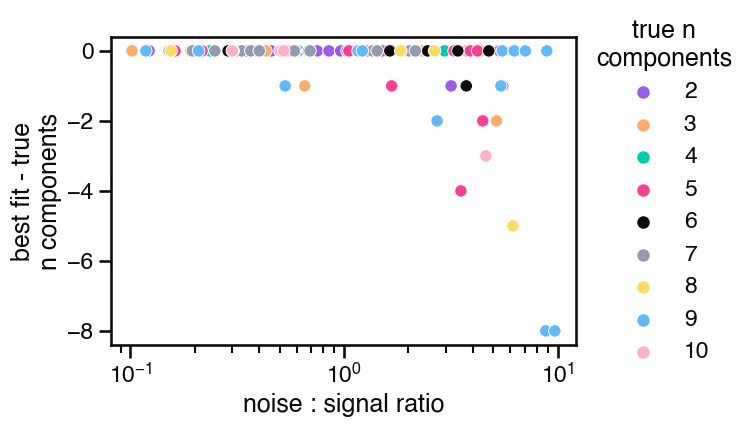

In [39]:
# plot true rank vs. optimal rank

# arrange data for plotting
rank_plot_df = simulation_info_df.copy()
rank_plot_df['min_cv_sse'] = rank_plot_df['simulation_id'].map(
    rank_optima_df.set_index('simulation_id')['relative_sse']
)
rank_plot_df['best fit rank - true rank'] = rank_plot_df['optimal_rank'] - rank_plot_df['simulation_rank']
rank_plot_df = rank_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
rank_plot_df['simulation_rank'] = rank_plot_df['simulation_rank'].astype(str)

# create plot
fig_1a, ax_1a = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='best fit rank - true rank', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_1a
)
plt.xlabel('noise : signal ratio');
plt.ylabel('best fit - true\nn components');
plt.xscale('log')
plt.legend(title='     true n\ncomponents', loc='center left', bbox_to_anchor=[1, .5]);
plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


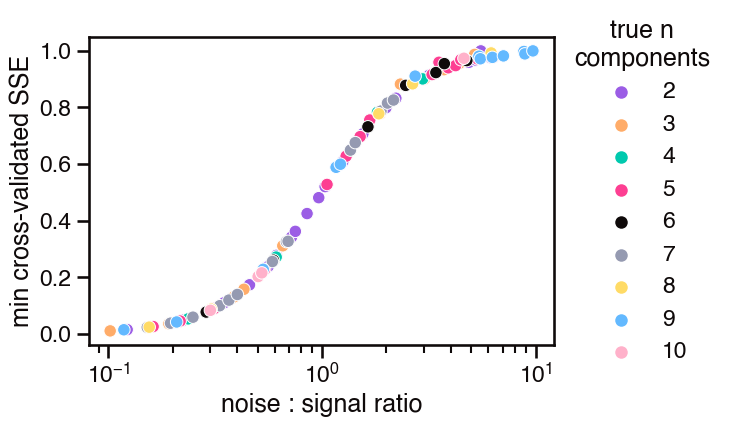

In [40]:
# plot relative sse of best cv replicate vs noise

# make plot
fig_s1, ax_s1 = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='min_cv_sse', 
    hue='simulation_rank', 
    data=rank_plot_df, 
    ax=ax_s1
);
plt.xlabel('noise : signal ratio');
plt.ylabel('min cross-validated SSE');
plt.xscale('log')
plt.legend(title='     true n\ncomponents', loc='center left', bbox_to_anchor=[1, .5]);
plt.savefig('best_sse_v_noise.png', bbox_inches='tight')


# Define optimal sparsity

Ground truth optimal sparsity is estimated by comparing cluster membership metrics between the fit models and the simulation ground truth.

Metrics to look at cluster membership of mode-0 factor matrix:
* Cosine similarity of mode-0 factor matrix support
* Precision-recall of mode-0 factor matrix support

These two metrics result in similar estimations of optimal sparsity. Max precision-recall is selected as the defining metric for ease of comprehension.


In [41]:
# find optimal lambda values based on cosine similarity (of values and support), precision-recall, and FMS

# make dataframe to store results
optimal_lambda_df = simulation_info_df.copy()
optimal_lambda_df['log noise:signal'] = np.log10(optimal_lambda_df['noise_level'])

# set up dataframe for selecting best lambda
lambda_df = gt_df_agg.copy()
lambda_df['optimal_rank'] = lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_df = lambda_df[lambda_df['rank'] == lambda_df['optimal_rank']].reset_index(drop=True)
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
lambda_df = lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)

# set up naming conventions (gt = ground truth)
# CSS = cosine similarity score, SCSS = support cosine similary score, MPRS = mean precision recall score
variables = [
    ('gt_fms_mean', 'fms'), 
    ('gt_cossim_f0_mean', 'css_f0'), 
    ('gt_precision_mean', 'precision'), 
    ('gt_recall_mean', 'recall'), 
    ('gt_precision_recall_mean', 'mprs'), 
    ('gt_sup_cossim_f0_mean', 'scss_f0')
]

# collect the max scores for each metric, along with the lambda values of the max
for (metric, var_name) in variables:
    # find max value of metric
    metric_df = lambda_df.loc[lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df['max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,max_css_f0,lambda_max_css_f0,max_precision,lambda_max_precision,max_recall,lambda_max_recall,max_mprs,lambda_max_mprs,max_scss_f0,lambda_max_scss_f0
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.989917,0.010,0.998648,1.0,1.0,0.000,0.929255,0.10,0.939429,0.10
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,...,0.988128,0.100,1.000000,10.0,1.0,0.010,0.901006,1.00,0.946657,1.00
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,...,0.994424,1.000,1.000000,10.0,1.0,0.100,0.785762,1.00,0.861565,1.00
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,...,0.962817,1.000,0.995765,10.0,1.0,0.010,0.743772,1.00,0.801578,1.00
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,...,0.999897,0.100,1.000000,1.0,1.0,0.010,0.953846,1.00,0.974741,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,...,0.997100,0.100,0.999362,10.0,1.0,0.001,0.895086,1.00,0.929117,1.00
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,...,0.999804,0.100,1.000000,10.0,1.0,0.010,0.952572,1.00,0.974665,1.00
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,...,0.992887,0.010,1.000000,1.0,1.0,0.000,0.916523,0.10,0.951508,0.10
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,...,0.999943,0.100,1.000000,10.0,1.0,0.010,0.964848,1.00,0.981530,1.00


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


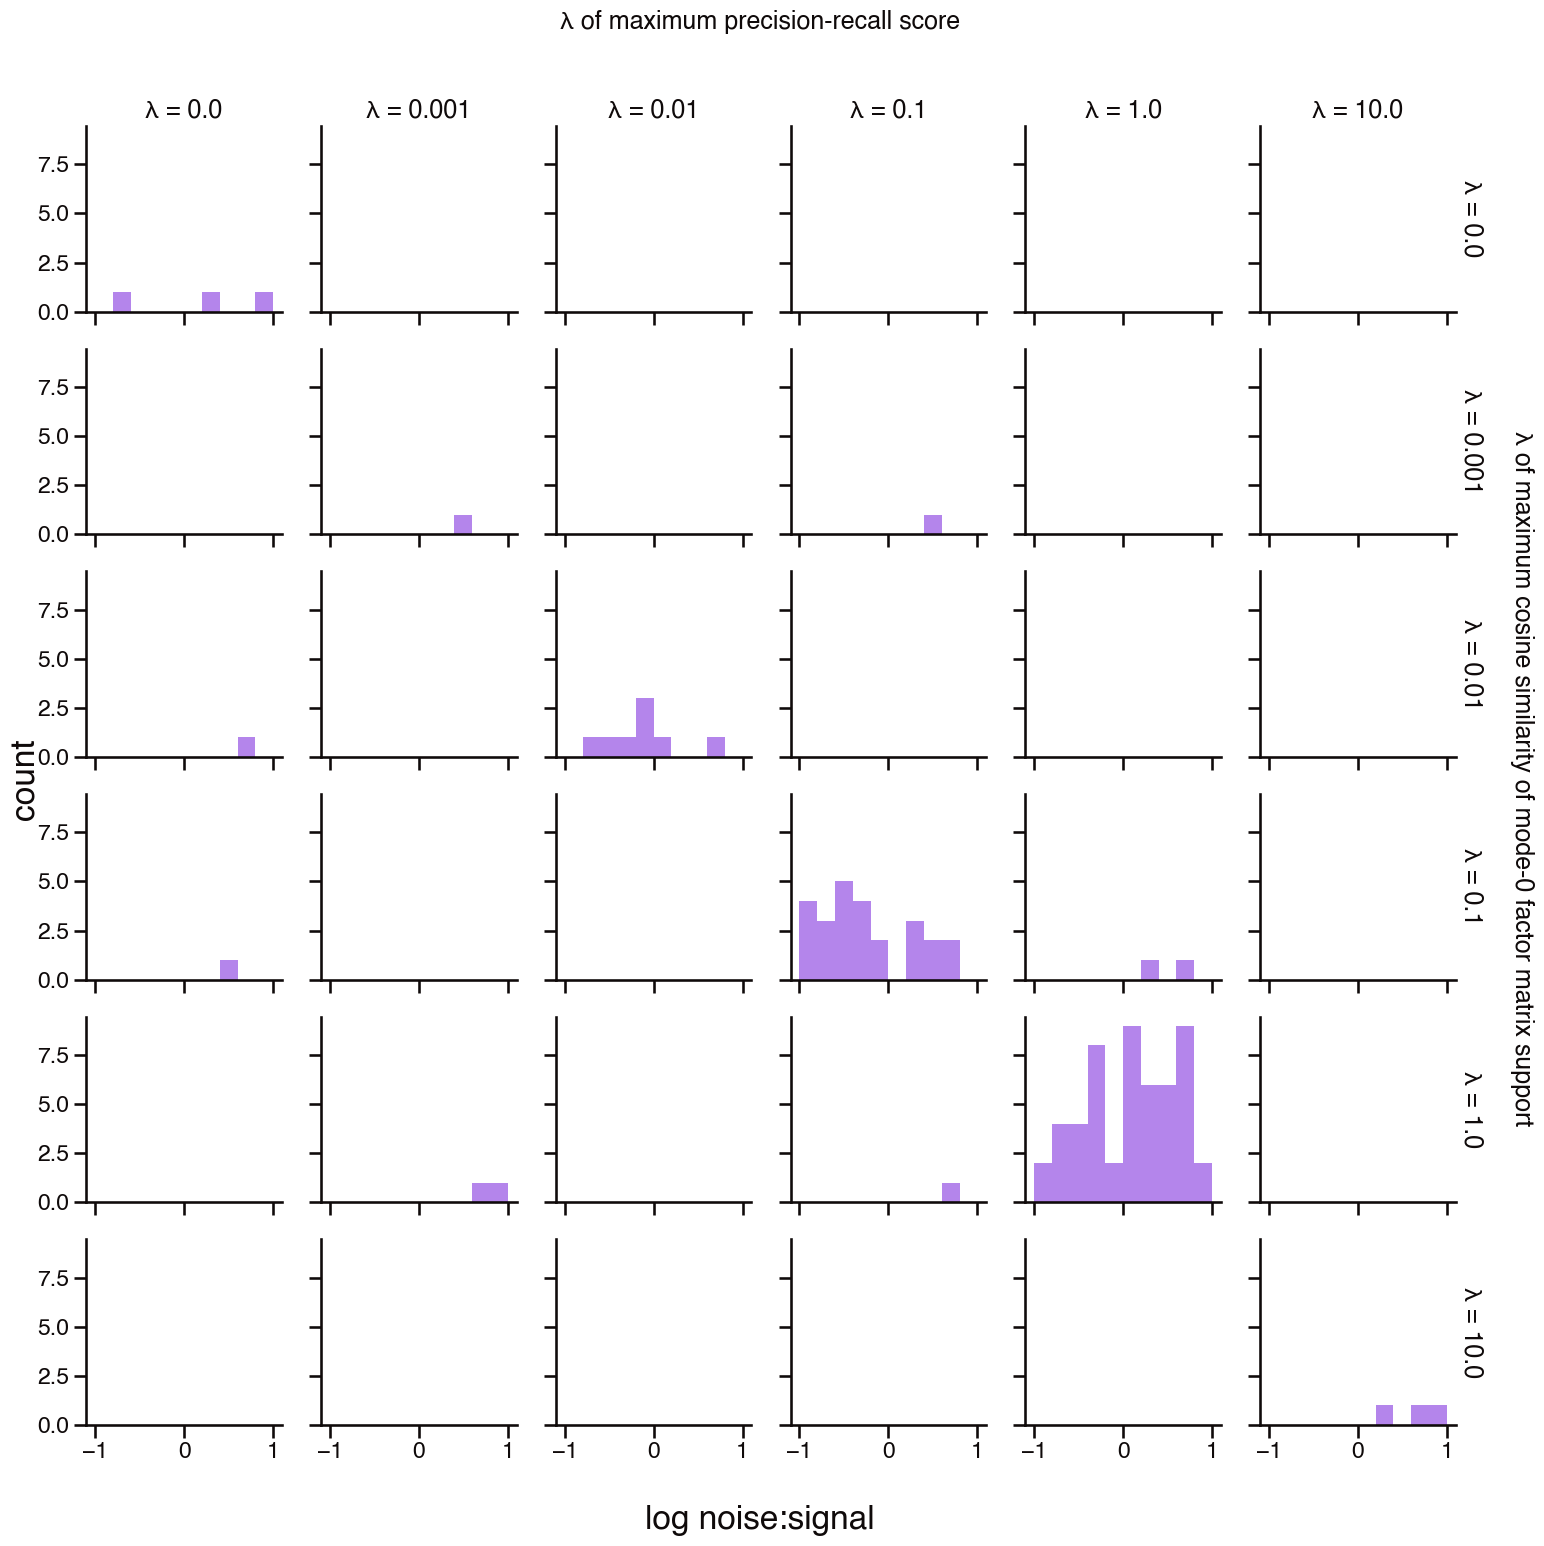

In [42]:
# plot a histogram grid comparing optimal lambdas according to precision recall & support cosine similarity

# parameterize FacetGrid
g = sns.FacetGrid(
    optimal_lambda_df, 
    row='lambda_max_scss_f0', 
    col='lambda_max_mprs', 
    margin_titles=True, 
    height=2.5
)

# plot data
g.map(sns.histplot, 'log noise:signal', color=sns.color_palette()[0], bins=10, binrange=(-1, 1));
# g.map(sns.histplot, 'factor0_density', color=sns.color_palette()[1], bins=10, binrange=(0, 1));
# g.map(sns.histplot, 'mode0_length', color=sns.color_palette()[2], bins=10, binrange=(0, 1000));

# adjust figure
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles(row_template='λ = {row_name}', col_template='λ = {col_name}');
# g.set_axis_labels('log noise:signal', 'count')
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='log noise:signal', fontdict={'fontsize':24});
g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
g.fig.text(.5, 1, ha='center', s='λ of maximum precision-recall score');
g.fig.text(1, .5, rotation=270, va='center', s='λ of maximum cosine similarity of mode-0 factor matrix support');


In [45]:
# set ground truth optimal sparsity as the sparsity of the maximum MPRS
optimal_lambda_df['optimal_lambda'] = optimal_lambda_df['lambda_max_mprs']

# map back to simulation_info_df
simulation_info_df['optimal_lambda'] = simulation_info_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['optimal_lambda']
)

# look at examples where optimal lambda (lambda of max MPRS) doesn't match lambda of max SCSS
optimal_lambda_df[optimal_lambda_df['optimal_lambda'] != optimal_lambda_df['lambda_max_scss_f0']]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_max_css_f0,max_precision,lambda_max_precision,max_recall,lambda_max_recall,max_mprs,lambda_max_mprs,max_scss_f0,lambda_max_scss_f0,optimal_lambda
15,15,3,"(333, 14, 32)",160.864731,5.179153,333,14,32,0.483077,0.558017,...,0.001,0.976137,1.0,0.864485,0.001,0.809545,0.001,0.859405,1.000,0.001
25,25,8,"(184, 79, 19)",174.835567,2.654867,184,79,19,0.950193,0.533428,...,0.100,1.000000,10.0,1.000000,0.001,0.954661,0.100,0.974879,0.001,0.100
28,28,2,"(309, 84, 96)",289.856795,3.173706,309,84,96,0.938048,0.031931,...,0.000,1.000000,10.0,0.612660,0.000,0.802548,0.000,0.994256,0.100,0.000
33,33,7,"(983, 37, 36)",420.494436,2.023802,983,37,36,0.427766,0.090858,...,0.100,0.962418,1.0,1.000000,0.001,0.774280,1.000,0.817092,0.100,1.000
48,48,9,"(365, 42, 72)",74.233201,8.804168,365,42,72,0.203379,0.064748,...,1.000,0.714004,1.0,0.915154,0.000,0.647371,0.001,0.686929,1.000,0.001
62,62,10,"(783, 32, 71)",724.086362,4.613912,783,32,71,0.924759,0.468251,...,0.010,0.999996,1.0,0.824946,0.000,0.908651,0.000,0.964238,0.010,0.000
84,84,8,"(692, 10, 44)",33.989934,6.187579,692,10,44,0.049118,0.917514,...,1.000,0.666667,10.0,1.000000,0.010,0.533021,0.100,0.424625,1.000,0.100
91,91,2,"(679, 64, 47)",601.982530,6.176310,679,64,47,0.886572,0.495475,...,0.100,1.000000,10.0,1.000000,0.001,0.915951,1.000,0.947626,0.100,1.000


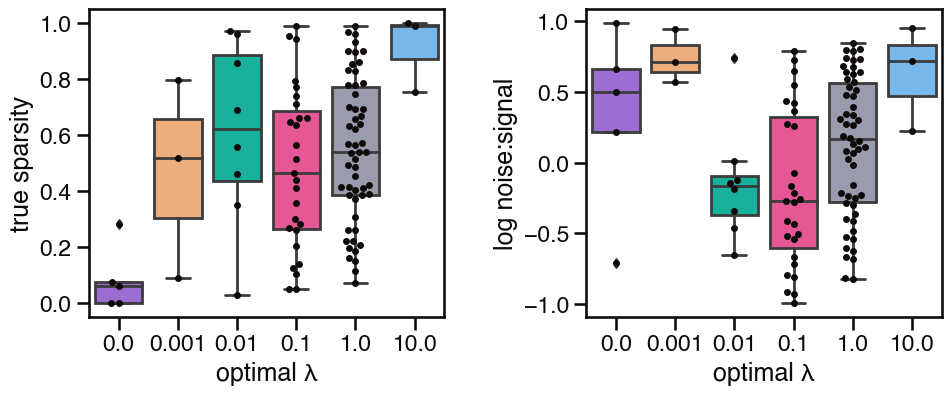

In [119]:
# plot optimal lambda by noise

# curate data
plot_df = optimal_lambda_df
plot_df['true sparsity'] = (1 - plot_df['factor0_density'])
plot_df = plot_df.sort_values('optimal_lambda')

# plot figure
fig, axis = plt.subplots(1, 2, figsize=[11, 4])
for i, var in enumerate(['true sparsity', 'log noise:signal']):
    sns.boxplot(
        x='optimal_lambda', 
        y=var, 
        data=plot_df, 
        ax=axis[i], 
        palette=[accent_colors[i] for i in [0, 1, 2, 3, 5, 7]]
    )
    sns.swarmplot(
        x='optimal_lambda', 
        y=var, 
        data=plot_df, 
        ax=axis[i], 
        color=accent_colors[4]
    )   
    
plt.subplots_adjust(wspace=0.4)
axis[0].set_xlabel('optimal λ');
axis[1].set_xlabel('optimal λ');
plt.savefig('defining-optimal-lambda.png', bbox_inches='tight')


# Compare methods of picking optimal sparsity

Within the optimal rank, find lambda corresponding to:
* Minimum of cross-validated SSE
* Inflection point of cross-validated SSE (maximum change in slope)
* Maximum of cross-validated FMS
* Inflection point of cross-validated FMS (minimum change in slope)
* Maximum lambda within 1 standard error of minimum cross-validated SSE 
* Maximum lambda within 1 standard error of maximum cross-validated FMS 

Score as sum of absolute values of difference between log(selected lambda) and log(optimal lambda)


In [125]:
# find optima of different selection criteria based on cross-validated scoring metrics

# set up dataframe for selecting best lambda based on cross validation data
cv_lambda_df = cv_df_agg.copy()
cv_lambda_df['optimal_rank'] = cv_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
cv_lambda_df = cv_lambda_df[cv_lambda_df['rank'] == cv_lambda_df['optimal_rank']]

# drop lambda=0 values, under the assumption that at least some regularization will be imposed on the model
cv_lambda_df = cv_lambda_df[cv_lambda_df['lambda'] != 0].reset_index(drop=True)

# calculate inflection points for SSE and FMS
for simid in cv_lambda_df.simulation_id.unique():
    # find SSE inflection point
    sse_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_sse_mean']
    d2ydx_sse = np.pad(np.diff(np.diff(sse_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[sse_vector.index, 'd2ydx_sse'] = d2ydx_sse
    # find FMS inflection point
    fms_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_fms_mean']
    d2ydx_fms = np.pad(np.diff(np.diff(fms_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[fms_vector.index, 'd2ydx_fms'] = d2ydx_fms
    
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
cv_lambda_df = cv_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)  

# for each simulation, calculate max lambda corresponding to SSE <= to min(SSE) + SEM(min(SSE))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_sse_mean'].idxmin(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_sse_mean'] + metric_df['cv_sse_sem']))
cv_lambda_df['min_cv_sse_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where SSE <= to min(SSE) + SEM(min(SSE))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_sse_mean'].le(cv_lambda_df['min_cv_sse_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_min_cv_sse_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# for each simulation, calculate max lambda corresponding to FMS >= to max(FMS) - SEM(max(FMS))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_fms_mean'].idxmax(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_fms_mean'] - metric_df['cv_fms_sem']))
cv_lambda_df['max_cv_fms_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where FMS >= to max(FMS) - SEM(max(FMS))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_fms_mean'].ge(cv_lambda_df['max_cv_fms_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_max_cv_fms_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# put together selection metrics
selection_metrics = [
    ('cv_sse_mean', 'min_cv_sse', 'min'), 
    ('cv_fms_mean', 'max_cv_fms', 'max'), 
    ('d2ydx_sse', 'sse_inflection', 'max'), 
    ('d2ydx_fms', 'fms_inflection', 'min')
]

for (metric, label, optimum) in selection_metrics:
    if optimum == 'min':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmin(), :]
    elif optimum == 'max':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df[label] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_{}'.format(label)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_min_cv_sse_1se,lambda_max_cv_fms_1se,min_cv_sse,lambda_min_cv_sse,max_cv_fms,lambda_max_cv_fms,sse_inflection,lambda_sse_inflection,fms_inflection,lambda_fms_inflection
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.01,0.01,0.087495,0.01,0.979923,0.001,0.617043,1.0,-0.992174,1.0
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,...,0.10,1.00,0.835865,0.10,0.965842,0.100,0.139185,1.0,-0.575190,1.0
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,...,1.00,1.00,0.903435,1.00,0.974733,1.000,0.037331,1.0,-0.939460,10.0
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,...,1.00,1.00,0.977159,1.00,0.905625,1.000,0.013197,10.0,-0.834641,10.0
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,...,0.10,1.00,0.058862,0.10,0.998547,0.100,0.580439,1.0,-0.601060,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,...,0.10,1.00,0.327441,0.10,0.995162,1.000,0.447566,1.0,-0.876179,10.0
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,...,0.10,1.00,0.139040,0.10,0.999615,1.000,0.307791,1.0,-0.998381,10.0
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,...,0.10,0.10,0.426423,0.01,0.985172,0.100,0.498036,1.0,-0.974906,1.0
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,...,0.10,1.00,0.130281,0.10,0.999833,1.000,0.548748,10.0,-0.999674,10.0


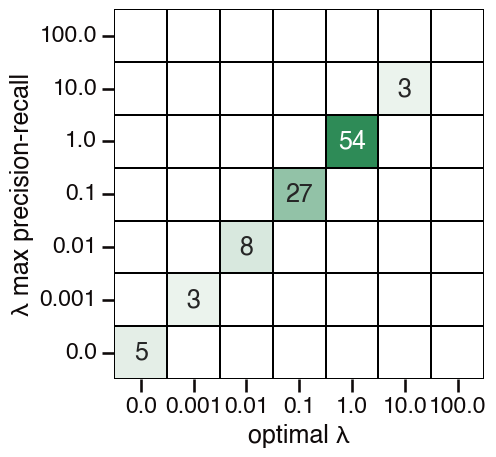

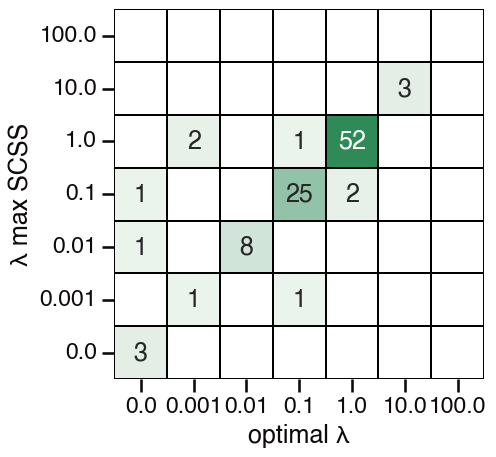

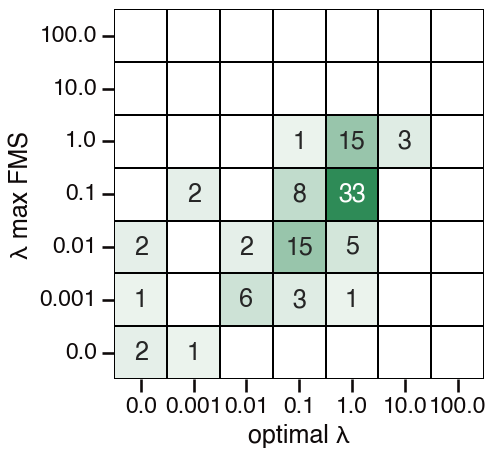

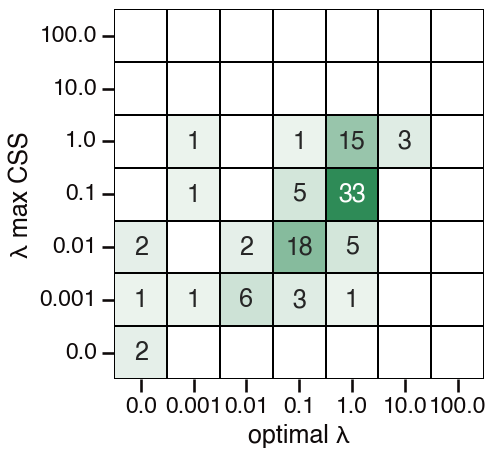

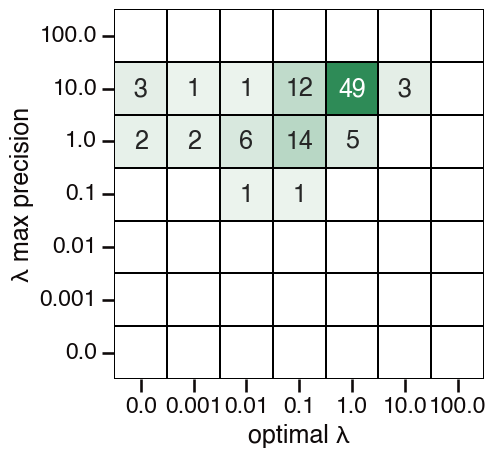

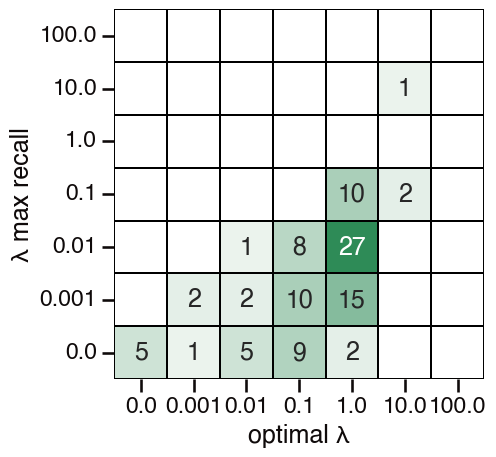

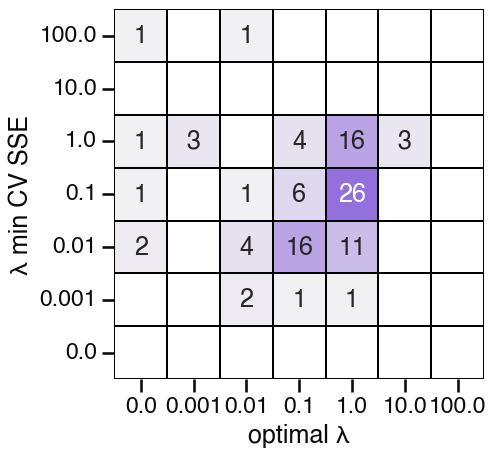

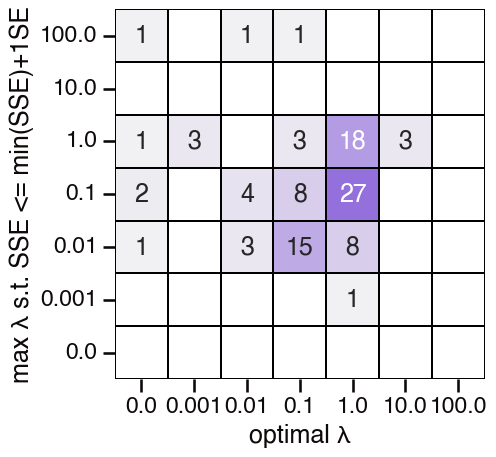

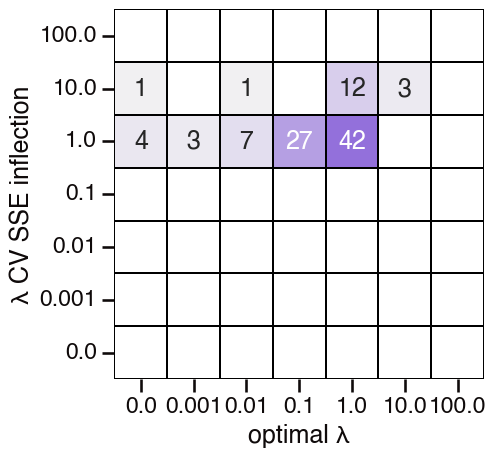

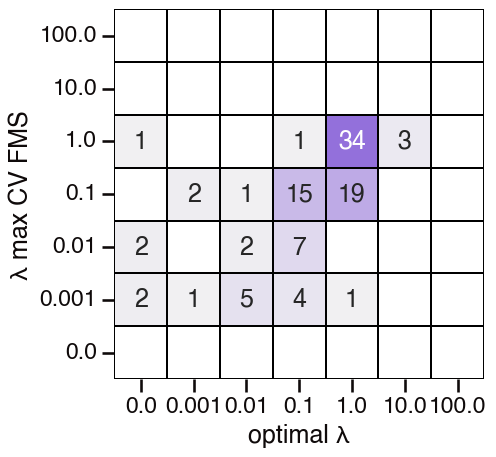

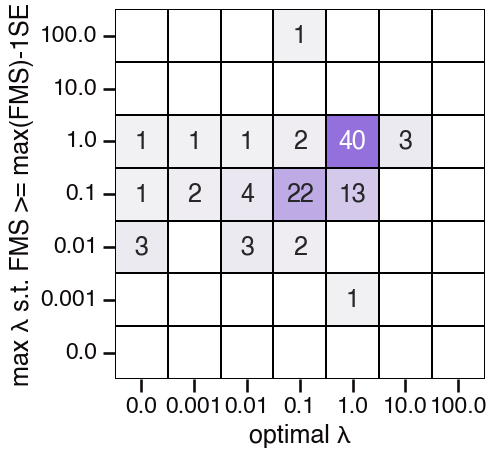

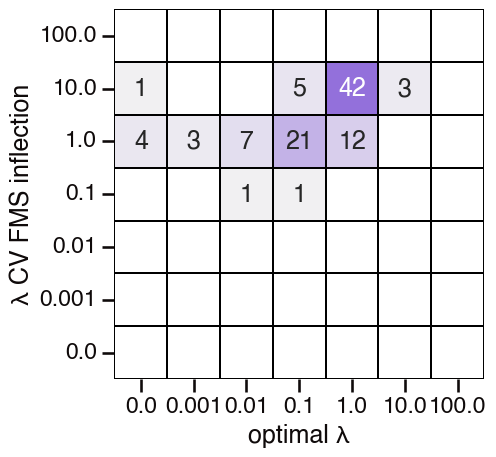

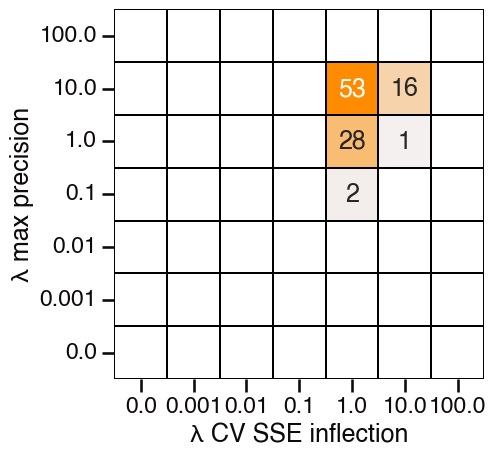

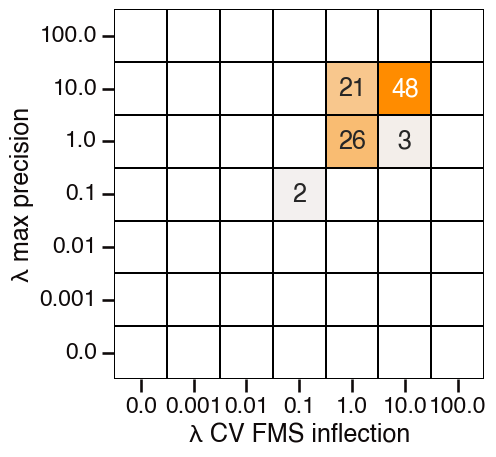

In [151]:
# make heatmap comparing optimal lambda values with methods of identification

# make template dataframe to house heatmap data
lambdas = results_df['lambda'].unique()
template_lambda_counts_df = pd.DataFrame(columns=lambdas, index=np.flip(lambdas)).fillna(0).astype(int)

# set up metrics to look at
comparison_values = [
    ('optimal_lambda', 'optimal λ', 'lambda_max_mprs', 'λ max precision-recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_scss_f0', 'λ max SCSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_fms', 'λ max FMS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_css_f0', 'λ max CSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_precision', 'λ max precision', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_recall', 'λ max recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse', 'λ min CV SSE', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse_1se', 'max λ s.t. SSE <= min(SSE)+1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_sse_inflection', 'λ CV SSE inflection', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms', 'λ max CV FMS', 'cv'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms_1se', 'max λ s.t. FMS >= max(FMS)-1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_fms_inflection', 'λ CV FMS inflection', 'cv'), 
    ('lambda_sse_inflection', 'λ CV SSE inflection', 'lambda_max_precision', 'λ max precision', 'other'), 
    ('lambda_fms_inflection', 'λ CV FMS inflection', 'lambda_max_precision', 'λ max precision', 'other')
]

# iterate through plots
for (col1, label1, col2, label2, dtype) in comparison_values:
    # arrange plot data
    plot_df = template_lambda_counts_df.copy()
    data_df = optimal_lambda_df[[col1, col2]].value_counts()
    for i, value in zip(data_df.index, data_df.values):
        plot_df.loc[i[1], i[0]] = value

    # set colormap based on datatype
    if dtype == 'gt':
        cmap = sns.color_palette('light:seagreen', as_cmap=True)
    elif dtype == 'cv':
        cmap = sns.color_palette('light:mediumpurple', as_cmap=True)
    else:
        cmap = sns.color_palette('light:darkorange', as_cmap=True)
        
    # make heatmap
    sns.heatmap(
        plot_df, 
        cmap=cmap, 
        annot=True, 
        linecolor='black', 
        linewidths=0.01, 
        cbar=False, 
        square=True, 
        mask=(plot_df == 0), 
    );
    plt.yticks(rotation=0)
    plt.xlabel(label1);
    plt.ylabel(label2);
    plt.savefig('{}-v-{}.png'.format(col1, col2), bbox_inches='tight')
    plt.show()
    

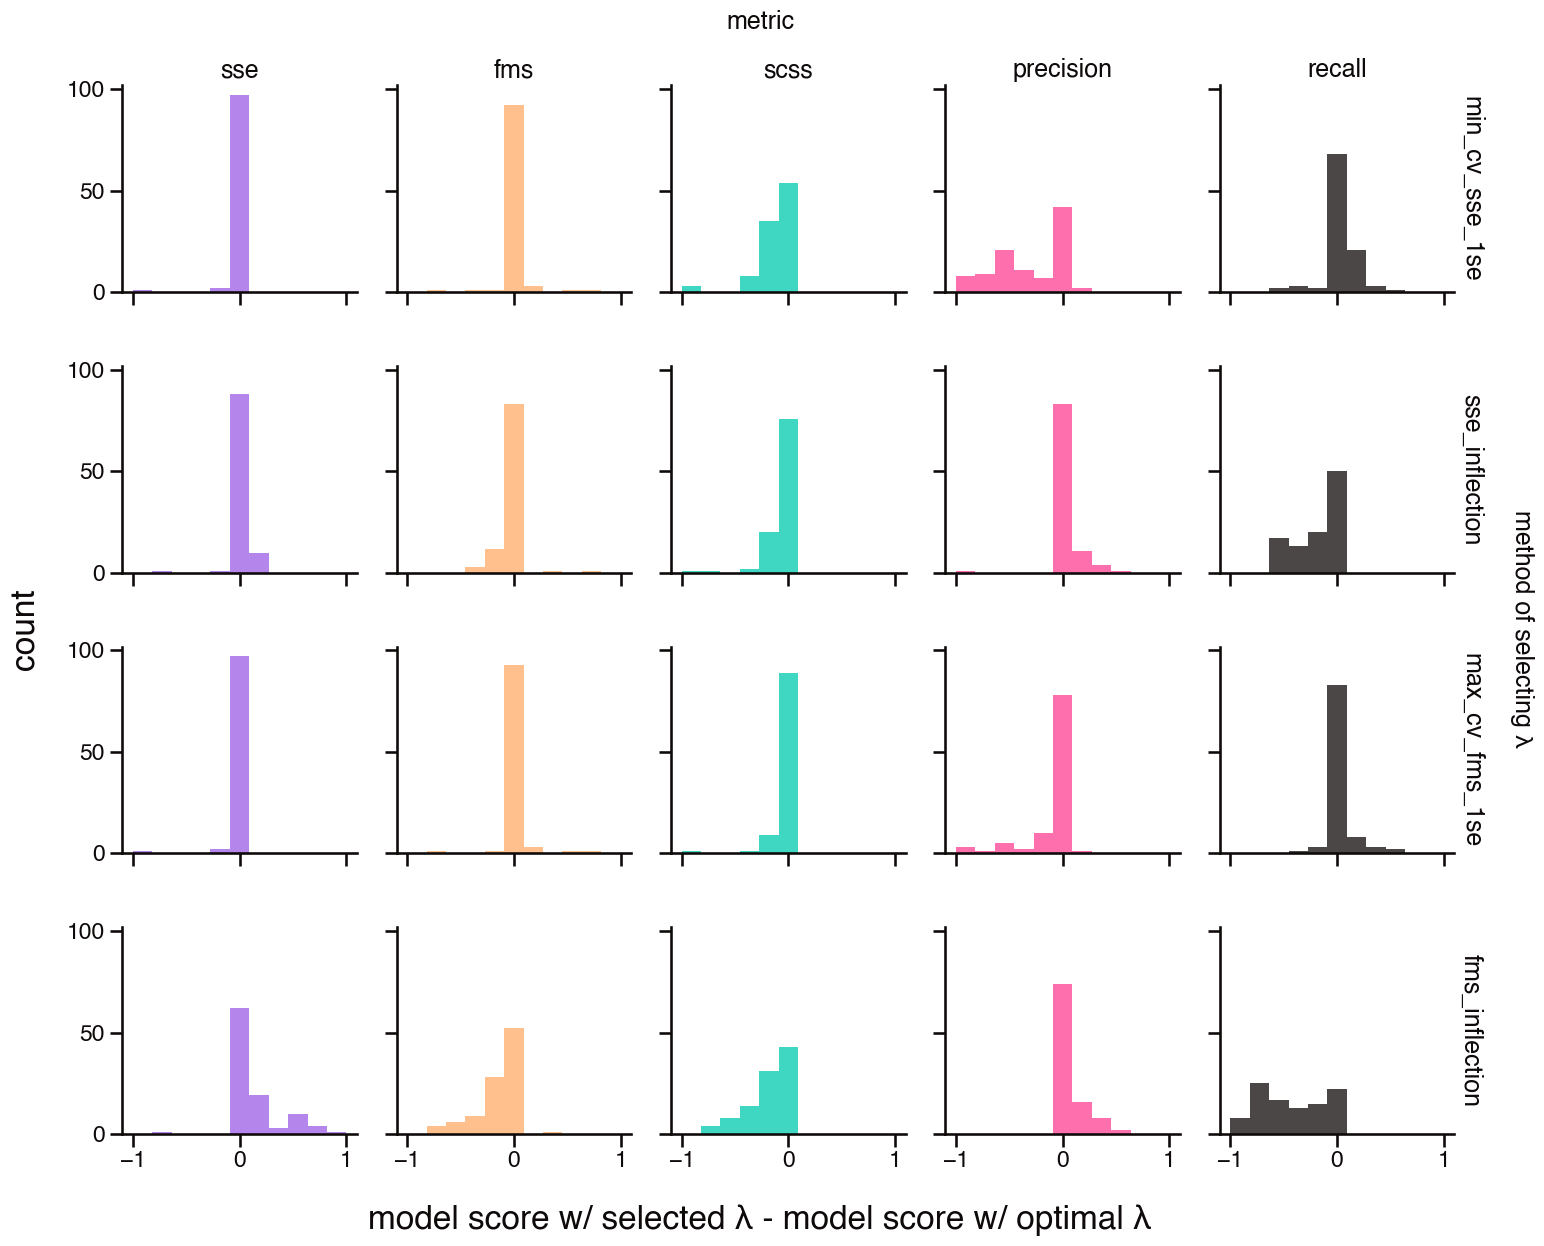

In [268]:
# look at difference between selected sparsity and optimal sparsity on a number of different metrics

# start with aggregated ground truth data
lambda_summary_df = gt_df_agg.copy()
# map back optimal rank and lambda, as well as noise
lambda_summary_df['optimal_rank'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_summary_df['optimal_lambda'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
lambda_summary_df['noise_level'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
# down-select to just optimal rank models
lambda_summary_df = lambda_summary_df[
    lambda_summary_df['rank'] == lambda_summary_df['optimal_rank']
].reset_index(drop=True)

# organize naming conventions for metrics
gt_metrics = ['gt_sse_mean', 'gt_fms_mean', 'gt_sup_cossim_f0_mean', 'gt_precision_mean', 'gt_recall_mean']
metrics = ['sse', 'fms', 'scss', 'precision', 'recall']

# collect metrics 
gt_optimal_models_df = lambda_summary_df[
    lambda_summary_df['lambda'] == lambda_summary_df['optimal_lambda']
].reset_index(drop=True).rename(columns={
    k: f'{v}_optimal_lambda' for (k, v) in zip(gt_metrics, metrics)
}).drop(columns=['rank', 'lambda', 'optimal_rank', 'optimal_lambda', 'noise_level', 
                 'gt_recovery_mean', 'gt_relevance_mean', 'gt_recovery_relevance_mean'])

# add metrics for each method of selecting sparsity level
methods = [
#     'min_cv_sse', 
    'min_cv_sse_1se', 
    'sse_inflection', 
#     'max_cv_fms', 
    'max_cv_fms_1se', 
    'fms_inflection'
]

# compile methods comparison df
methods_comparison_df = pd.DataFrame()
for method in methods:
    working_df = lambda_summary_df.copy()
    # map method lambdas on working_df
    working_df['selected_lambda'] = working_df['simulation_id'].map(
        optimal_lambda_df.set_index('simulation_id')['lambda_{}'.format(method)]
    )
    # down-select to models with selected lambda
    working_df = working_df[working_df['lambda'] == working_df['selected_lambda']].rename(columns={
        k: f'{v}_selected_lambda' for (k, v) in zip(gt_metrics, metrics)
    })
    method_df = pd.merge(left=gt_optimal_models_df, right=working_df, on='simulation_id')
    # calculate differences
    for metric in metrics:
        method_df[metric] = method_df[f'{metric}_selected_lambda'] - method_df[f'{metric}_optimal_lambda']
    method_df['method'] = method
    if len(methods_comparison_df) == 0:
        methods_comparison_df = method_df
    else:
        methods_comparison_df = pd.concat([methods_comparison_df, method_df])

# melt methods comparison df for easy plotting
methods_comparison_df = methods_comparison_df.melt(
    id_vars=['simulation_id', 'method'], value_vars=metrics, var_name='metric'
)

# # plot histograms for each method
# for method in methods:
#     # down-select to the method
#     plot_df = methods_comparison_df[methods_comparison_df['method'] == method]
# #     # plot just the errors (get rid of where difference = 0)
# #     plot_df = plot_df[plot_df['value'] != 0]
#     # make plot
#     g = sns.displot(data=plot_df, x='value', hue='metric', bins=11, col='metric')
#     # adjust figure
#     g.set_titles(col_template='{col_name}');
#     # g.set_axis_labels('log noise:signal', 'count')
#     g.set_axis_labels('', '')
# #     g.fig.text(.5, 0, ha='center', s='log noise:signal', fontdict={'fontsize':24});
# #     g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
# #     g.fig.text(.5, 1, ha='center', s='λ of maximum precision-recall score');
# #     g.fig.text(1, .5, rotation=270, va='center', s='λ of maximum cosine similarity of mode-0 factor matrix support');

# #     plt.xlim([-1, 1])
# #     plt.xlabel('selected lambda - optimal lambda')
# #     plt.title('{}'.format(metric))
# #     plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
#     plt.show()
    
g = sns.FacetGrid(methods_comparison_df, row='method', col='metric', hue='metric', margin_titles=True)
g.map(sns.histplot, 'value', bins=11, binrange=(-1, 1));
g.set_titles(row_template='{row_name}', col_template='{col_name}');
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='model score w/ selected λ - model score w/ optimal λ', fontdict={'fontsize':24});
g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
g.fig.text(.5, 1, ha='center', s='metric');
g.fig.text(1, .5, rotation=270, va='center', s='method of selecting λ');

# add sparsity to this?
    

# Model robustness to mis-specification

What happens when a sub-optimal sparsity or rank is selected?


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


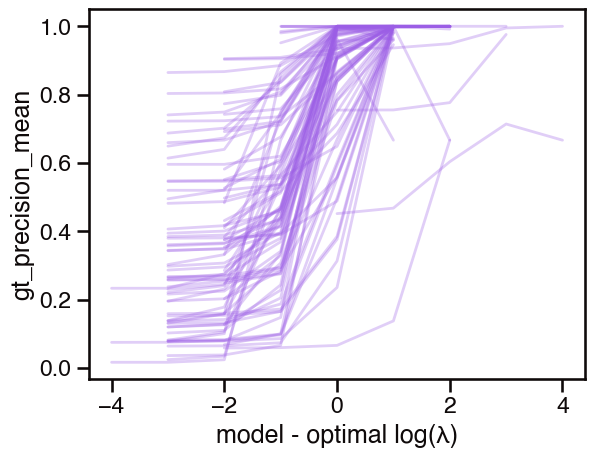

In [148]:
# lambda mis-specification

# start with aggregated ground truth data
misspec_lambda_df = gt_df_agg.copy()
# map back optimal rank and lambda, as well as noise
misspec_lambda_df['optimal_rank'] = misspec_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
misspec_lambda_df['optimal_lambda'] = misspec_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
misspec_lambda_df['noise_level'] = misspec_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
# down-select to just optimal rank models
misspec_lambda_df = misspec_lambda_df[
    misspec_lambda_df['rank'] == misspec_lambda_df['optimal_rank']
].reset_index(drop=True)

# drop lambda = 0 experiments
misspec_lambda_df = misspec_lambda_df[misspec_lambda_df['lambda'].gt(0)]
# calculate difference between optimal lambda and model lambda
misspec_lambda_df['model - optimal log(λ)'] = np.log10(misspec_lambda_df['lambda']) - np.log10(misspec_lambda_df['optimal_lambda'])

# drop experiments where precision is zero b/c that only happens when the factors are totally zeroed out
misspec_lambda_df = misspec_lambda_df[misspec_lambda_df['gt_precision_mean'].gt(0)]

# plot lineplot
sns.lineplot(
    x='model - optimal log(λ)', 
    y='gt_precision_mean', 
    units='simulation_id', 
#     hue='simulation_rank', 
#     hue='noise_level', 
    data=misspec_lambda_df, 
    err_style='bars', 
    estimator=None, 
    alpha=0.3
);
# plt.ylabel('{} model vs. true factors'.format(metric));
# plt.legend(title='noise level', loc='center left', bbox_to_anchor=[1, 0.5])
